# Introduction 

In this project, the total site electricity usage of a housing unit, in kilowatt-hour, is predicted using some features provided by Residential Energy Consumption Survey (RECS) in 2009.  
To develop a comprehensive predictive model, we one-by-one test different regression models arranged from simplest to the most complex and evaluate each.   First of all, the feature correlation is utilized to find the features correlated directly with the  KWH field. If the KWH field is a multiple of one of the features, the correlation will be close to one; consequently, the best predictive model will be found. 
Secondly, linear regressions ranging from simple regression to polynomial regression will be tested. Finally, if the previous models do not result in an acceptable performance (e.g., the accuracy >0.99), nonlinear models such as Kernel techniques and neural networks are taken into account. The outline of methodolgy for finding the best model is as follows:

<ul>
<li>Preprocessing and Data Engineering Steps</li>
<li>Searching for Axiomatic Solutions</li>
<li>Feature Selection for Regression</li>
<li>Final Model Architecture</li>
</ul>

# Methodology
## Preprocessing and Data Engineering 

In this part, preprocessing transformations applied to the complete dataset are described in detail. These steps will be used again within the model pipeline after splitting the dataset into training, validation and test sets.  
Before starting data processing, we must first load the dataset in the ensuing block. The directory of the dataset is located beside the codes folder. The dataset, converted to a Pandas DataFrame, is a CSV file so that columns and rows refer to features and samples, respectively. Moreover, required packages for this project are imported below, and the parameters and initial variables are set here. 


In [18]:
import os
from pathlib import Path
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline , Pipeline
from joblib import dump, load
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#Dataset address
source_path = '../'
dataset_dir = 'data'
dataset_file_name = 'recs2009_public.csv'
dataset_path = os.path.join(source_path + dataset_dir, dataset_file_name)

#Best Model Address 
experiment_number = 1
experiment_path = '../data/models/experiment{}/'.format(experiment_number)

#Parameters of the model and Variables
random_state = 42
Number_folds = 5
test_size_ratio = 0.33
var_threshold_feature_select = 0.6

#loading dataset 
dataset_df_raw = pd.read_csv(dataset_path)
dataset_df = dataset_df_raw.copy()

#Create a directory for saved model
Path(experiment_path).mkdir(parents=True, exist_ok=True)

C:\Users\rayka\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Feature's Type ِِDetermination
The first step toward preprocessing is to distinguish between categorical and numerical features. To this end, the types of features are printed in this block. The name of features whose type is object are put in a set.

In [20]:
# Printing types of features
print(dataset_df.dtypes)

# separating Categorical features
cat_feature_df = dataset_df.select_dtypes(include=['object'])
categorical_feature = set(cat_feature_df.keys())
print("The set of categorical features:",categorical_feature)

DOEID                  int64
REGIONC                int64
DIVISION               int64
REPORTABLE_DOMAIN      int64
TYPEHUQ                int64
                      ...   
WSF                  float64
OA_LAT                 int64
GWT                    int64
DesignDBT99            int64
DesignDBT1             int64
Length: 940, dtype: object
The set of categorical features: {'METROMICRO', 'UR', 'NKRGALNC', 'NOCRCASH', 'IECC_Climate_Pub'}



Contemplating the value of features spotted by the previous block, we could realize two columns of NKRGALNC and NKRGALNC are numerical, but they have missing values filled by ".". 

In [21]:
print("Frequency of appearance of each Value for NOCRCASH",dataset_df["NOCRCASH"].value_counts())
print("Frequency of appearance of each Value for NKRGALNC",dataset_df["NKRGALNC"].value_counts())

Frequency of appearance of each Value for NOCRCASH -2    9958
-2    2028
1       18
3       10
4       10
5        9
2        7
1        6
16       4
6        3
8        3
12       3
24       2
15       2
3        2
55       2
.        2
4        2
12       2
10       1
20       1
28       1
40       1
6        1
20       1
24       1
55       1
10       1
25       1
Name: NOCRCASH, dtype: int64
Frequency of appearance of each Value for NKRGALNC -2    9958
-2    2028
5       42
3       11
1       10
10       8
10       5
5        5
15       2
.        2
1        2
3        1
77       1
2        1
30       1
20       1
15       1
8        1
8        1
2        1
55       1
Name: NKRGALNC, dtype: int64


In the below cell, missing values of the two aforementioned columns can be replaced by NaN or -2. These features are converted to the numerical type after fixing the problem caused by missing values. 

In [22]:
# Filling missing values of two specific columns (NKRGALNC and NKRGALNC)  with -2
# pd.to_numeric(dataset_df["NKRGALNC"], errors='coerce') 
for i, value in enumerate(dataset_df["NKRGALNC"]):
    if value == ".":
        dataset_df["NKRGALNC"][i] = -2
dataset_df["NKRGALNC"] = pd.to_numeric(dataset_df["NKRGALNC"],downcast='float')

for i, value in enumerate(dataset_df["NOCRCASH"]):
    if value == ".":
        dataset_df["NOCRCASH"][i] = -2        
dataset_df["NOCRCASH"] = pd.to_numeric(dataset_df["NOCRCASH"],downcast='float')

C:\Users\rayka\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\rayka\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


### Encoding Categorical Features
Most of the regression models support numbers as input variables. In this sense, categorical features should be encoded so that ordinal numbers are assigned to ordered values of a categorical feature. Once the modification occurs,  each feature will be a number. 

In [23]:
ord_enc = OrdinalEncoder()
for feature in  categorical_feature :
    dataset_df[feature] = ord_enc.fit_transform(dataset_df[[feature]])

Firs of all, the correlation between KWH and other features are derived from the covariance matrix of the features.
Then, KWH column is extracted from the main dataset below. Additionally, the dataset is transformed from Pandas Dataframe into a NumPy array since I do not use distributed operating system for processing; moreover, the size of the data is not that big. Training and test sets are separated here as well. 

In [24]:
#Creating Covariance Matrix of features  and measure how much KWH is correlated with others
feature_cor = dataset_df.corr()["KWH"]
KWH_feature_cor = feature_cor.to_numpy()

# Extracting the target value from dataset
y = np.array(dataset_df.pop("KWH"))

# dataframe to numpy array
dataset = dataset_df.to_numpy()   

#train test split
dataset_train, dataset_test, y_train, y_test = train_test_split(dataset, y, test_size = test_size_ratio, random_state = random_state)

### Feature Selection
Feature reduction and feature selection are two main tools for dimensionality reduction in data engineering. Feature reduction, e.g., Principal Component Analysis (PCA), is a kind of projection mapping dataset from the main space into another space with a lower dimension. On the other hand, without changing the features, a feature selection module simply selects and removes attributes. Feature selection can be performed in unsupervised or supervised fashions. 

In this project, both unsupervised feature selection as well as supervised one are only deployed for dimensionality reduction. In this part, features with low variance are removed in an unsupervised manner. In other words, the features' exclusion is happening without paying attention to the target value, KWH field. 



In [26]:
sel = VarianceThreshold(threshold=(var_threshold_feature_select * (1 - var_threshold_feature_select)))
dataset_train_A = sel.fit_transform(dataset_train)
dataset_test_A = sel.transform(dataset_test)

#number of features before supervised feature selection 
print("Transformed dataset size after unsupervised feature selection", dataset_train_A.shape)

Transformed dataset size after unsupervised feature selection (8095, 444)


Feature normalization is another preprocessing step used to scale features so that all features stay in the same range ( between zero and one). 

In [44]:
# scaling features and normalization 
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler1 = preprocessing.MinMaxScaler()

dataset_train_normalized = min_max_scaler.fit_transform(dataset_train_A)
dataset_test_normalized = min_max_scaler.transform(dataset_test_A)

y_train_normalized = min_max_scaler1.fit_transform(y_train.reshape(y_train.shape[0],-1))
y_test_normalized = min_max_scaler1.transform(y_test.reshape(y_test.shape[0],-1))

## Searching for Axiomatic Solutions

In this section, we are going to find the features which are directly related to the target value. To put it another way, axiomatic solutions of the regression problem are detected here. 

In previous blocks, correlation between target value and the other features were calculated. The features whose correlation with the target value is approximately 1, are detected. 

In [ ]:
print(np.where(abs(KWH_feature_cor) > 0.9), "IDs of features whose absolut value of correlation with KWH is higher than 0.9")

After investigation through the codebook of features, the aforementioned arrays, which have the highest correlation with KWH, correspond to the total electricity usage in KWH and BTC, respectively. If BTC columns exist among features, a simple unit converter can be utilized as a predictive model. Hence, we eliminate this feature.  

In the next step, we verify whether the summation of some features produces the KWH.

In [ ]:
reg = LinearRegression().fit(dataset_train, y_train)
reg.score(dataset_train, y_train)
print(np.where(reg.coef_>0.95),"IDs of features whose linear combination produces KWH")

By looking at the correspondence between features' names and indices above, I realized that the element-wise summation of a set of five features including KWHSPH, KWHCOL, KWHWTH, KWHRFG, and KWHOTH is KWH. Furthermore, the summation of BTUELSPH, BTUELCOL, BTUELWTH, and BTUELRFG equals total usage of electricity in BTU. Therefore, An axiomatic relationship between these features and the target value of prediction can be considered as a model. To avoid this fact, we assume that we do not have these features and remove these columns. 

In [11]:
dataset_train2 = np.delete(dataset_train, np.s_[839:850],1)
dataset_test2 = np.delete(dataset_test, np.s_[839:850],1)

## Feature Selection for Regression

In this part, SelectKBest, a supervised feature selection function, is applied to the input to select features and regressors. The features are selected based on scores corresponding to their significance for the regression task.  

In our model, some univariate linear regression tests are utilized to assign a p-value to each feature. The procedure occurs in 2 steps:
<ol>
<li>The correlation between each regressor and the target is computed, that is, $\dfrac{(X[:, i] - mean(X[:, i])) \times (y - mean_y))}{(std(X[:, i]) \times std(y)}$.</li>
<li>each correlation is converted to an F score and then to a p-value </li>
</ol>


In the following example, we choose the ten most important features, but the number of selected features varies within the main model.



In [12]:
# define feature selection
fs = SelectKBest(score_func = f_regression, k = 100)

# apply feature selection
print(dataset_train2.shape)
X_selected = fs.fit_transform(dataset_train2, y_train)
print(X_selected.shape)

(8095, 928)
(8095, 100)


C:\Users\rayka\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\rayka\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\rayka\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\rayka\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\rayka\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\rayka\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid val

## Final Model Architecture

Some steps, such as encoding, are bypassed within the pipeline to simplify the model. 
We use the result of previous codes for encoding categorical features and removing features causing axiomatic solutions. 
Min-Max feature normalization is added to the pipeline so we can make sure all features are in the same range (between zero and one). K-fold cross-validation is applied to the training set for tuning hyperparameters of models and fairly comparing the performance of each model. Before applying regression, features are selected in a supervised manner. The number of selected features is another hyperparameter of the model. This parameter's best value will be defined later by inferring the result derived from the cross-validation part.  

The least-squares Linear Regression is the first applicable model for this dataset. In this model, the features are linearly projected using  learnable coefficients $ w = (w_1,...,{w}_{number of features})$. These learnable weights are measured by optimizing the residual sum of squares between the projected features and the observed target value. The score used for evaluation is the coefficient of determination $R^2$ of the prediction.
The coefficient $R^2$ is defined as $1 - \dfrac{\sum{(y_{true} - y_{pred})^2} }{\sum((y_{true} - y_{true}.mean())^2 }  $. 

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a $R^2$ score of 0.0.

The pipeline is fit to the training set and  evaulated by validation set across different number of selected features. At each step, the best model with the largest score is cached. 

In [60]:
# Training validation split 
kf = KFold(n_splits = Number_folds, random_state = random_state, shuffle=True)

# Initial value of parameters and lists
best_performance = 0
accuracy_mean = []
num_features_1 = dataset_train_A.shape[1]

for Num_important_attr in range(1, num_features_1):
    
    # initializing mean score
    score_mean = 0
    
    # instantiating pipeline 
    scaler = preprocessing.MinMaxScaler()
    sel1 = VarianceThreshold(threshold = (var_threshold_feature_select * (1 - var_threshold_feature_select)))
    fs2 = SelectKBest(score_func = f_regression, k = Num_important_attr)
    pipeline = Pipeline([
      ('Unsupervised_Feature_Selection', sel1),
      ('Feature_Normalization', preprocessing.MinMaxScaler()),
      ('Supervised_Feature_Selection', fs2),
      ('Regression_Model', LinearRegression())
       ])
    
    print("Number of selected features for regression:", Num_important_attr)
    
    for train_index, val_index in kf.split(dataset_train2):
        
        # loading Training and Validation sets
        X_train, X_val = dataset_train2[train_index], dataset_train2[val_index]
        y_train_B, y_val = y_train[train_index], y_train[val_index]

        # fitting model to each fold
        pipeline.fit(X_train, y_train_B)
        score_mean += pipeline.score(X_val, y_val)/Number_folds 
    
    accuracy_mean.append(score_mean)
    
    # saving the best model among all hyperparameters
    if score_mean > best_performance:
        best_performance = score_mean
        dump (pipeline, experiment_path + 'Best_Model')

Number of selected features for regression: 1
Number of selected features for regression: 2
Number of selected features for regression: 3
Number of selected features for regression: 4
Number of selected features for regression: 5
Number of selected features for regression: 6
Number of selected features for regression: 7
Number of selected features for regression: 8
Number of selected features for regression: 9
Number of selected features for regression: 10
Number of selected features for regression: 11
Number of selected features for regression: 12
Number of selected features for regression: 13
Number of selected features for regression: 14
Number of selected features for regression: 15
Number of selected features for regression: 16
Number of selected features for regression: 17
Number of selected features for regression: 18
Number of selected features for regression: 19
Number of selected features for regression: 20
Number of selected features for regression: 21
Number of selected fea

Number of selected features for regression: 174
Number of selected features for regression: 175
Number of selected features for regression: 176
Number of selected features for regression: 177
Number of selected features for regression: 178
Number of selected features for regression: 179
Number of selected features for regression: 180
Number of selected features for regression: 181
Number of selected features for regression: 182
Number of selected features for regression: 183
Number of selected features for regression: 184
Number of selected features for regression: 185
Number of selected features for regression: 186
Number of selected features for regression: 187
Number of selected features for regression: 188
Number of selected features for regression: 189
Number of selected features for regression: 190
Number of selected features for regression: 191
Number of selected features for regression: 192
Number of selected features for regression: 193
Number of selected features for regressi

C:\Users\rayka\anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 0.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Number of selected features for regression: 259
Number of selected features for regression: 260
Number of selected features for regression: 261
Number of selected features for regression: 262
Number of selected features for regression: 263
Number of selected features for regression: 264
Number of selected features for regression: 265
Number of selected features for regression: 266
Number of selected features for regression: 267
Number of selected features for regression: 268
Number of selected features for regression: 269
Number of selected features for regression: 270
Number of selected features for regression: 271
Number of selected features for regression: 272
Number of selected features for regression: 273
Number of selected features for regression: 274
Number of selected features for regression: 275
Number of selected features for regression: 276
Number of selected features for regression: 277
Number of selected features for regression: 278
Number of selected features for regressi

C:\Users\rayka\anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 0.69s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Number of selected features for regression: 283
Number of selected features for regression: 284
Number of selected features for regression: 285
Number of selected features for regression: 286
Number of selected features for regression: 287
Number of selected features for regression: 288
Number of selected features for regression: 289
Number of selected features for regression: 290
Number of selected features for regression: 291
Number of selected features for regression: 292
Number of selected features for regression: 293
Number of selected features for regression: 294
Number of selected features for regression: 295
Number of selected features for regression: 296
Number of selected features for regression: 297
Number of selected features for regression: 298


C:\Users\rayka\anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Number of selected features for regression: 299
Number of selected features for regression: 300
Number of selected features for regression: 301
Number of selected features for regression: 302
Number of selected features for regression: 303
Number of selected features for regression: 304
Number of selected features for regression: 305
Number of selected features for regression: 306
Number of selected features for regression: 307
Number of selected features for regression: 308
Number of selected features for regression: 309
Number of selected features for regression: 310
Number of selected features for regression: 311
Number of selected features for regression: 312
Number of selected features for regression: 313
Number of selected features for regression: 314
Number of selected features for regression: 315
Number of selected features for regression: 316
Number of selected features for regression: 317
Number of selected features for regression: 318
Number of selected features for regressi

C:\Users\rayka\anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 0.77s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Number of selected features for regression: 438


C:\Users\rayka\anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.59s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Number of selected features for regression: 439
Number of selected features for regression: 440
Number of selected features for regression: 441
Number of selected features for regression: 442
Number of selected features for regression: 443


It is worth mentioning that this is one of the simplest models for predicting the KWH field. Regularization terms can be added to the loss function to develop a simpler model as well.

Once the model is chosen based on the cross-validation module's score, the selected model with tunned parameters can be applied to the whole training set. Therefore, the final predictive model for KWH is ready. 

In [82]:
#finding optimum k for the architecture
optimum_Num_important_attr = 300
scaler = preprocessing.MinMaxScaler()
sel1 = VarianceThreshold(threshold = (var_threshold_feature_select * (1 - var_threshold_feature_select)))
fs2 = SelectKBest(score_func = f_regression, k = optimum_Num_important_attr)
pipeline_main = Pipeline([
  ('Unsupervised_Feature_Selection', sel1),
  ('Feature_Normalization', preprocessing.MinMaxScaler()),
  ('Supervised_Feature_Selection', fs2),
  ('Regression_Model', LinearRegression())
   ])

#save model
dump (pipeline_main, experiment_path + 'Best_Model_main')

#fitting model to the complete training set
pipeline_main.fit(dataset_train2, y_train)

Pipeline(memory=None,
         steps=[('Unsupervised_Feature_Selection',
                 VarianceThreshold(threshold=0.15999999999999998)),
                ('Feature_Normalization',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('Supervised_Feature_Selection',
                 SelectKBest(k=300,
                             score_func=<function f_regression at 0x000001FA8CD279D8>)),
                ('Regression_Model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

# Result

The cross-validation score is plot across the number of selected features. As we can observe below,  two main breaks in the diagram refer to candidates for the optimum number of selected features. Additionally, the mean score of cross-validation approaches 1, which justifies that the model is fitted properly. Hence, there is no need to apply other complicated models. 

The final pipeline applied to the test set results in the best $R^2$ score of  0.9964. 

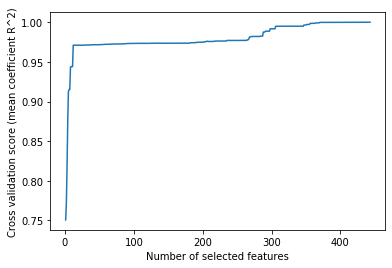

Best score of the model: 0.9999999998676401
Final score for test set 0.9999999998383979
Final score for test set for main pipeline 0.9964487798053792


In [83]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of selected features")
plt.ylabel("Cross validation score (mean coefficient R^2)")
plt.plot(range(1,
               num_features_1),
         accuracy_mean)
plt.show()

print( "Best score of the model:", best_performance)

# load model
pipeline1 = load(experiment_path + 'Best_Model') 

# prediction over test set
print("Final score for test set", pipeline1.score(dataset_test2,y_test))

print("Final score for test set for main pipeline", pipeline_main.score(dataset_test2,y_test))